# Sentiment Analysis

## Introduction

* **Natural Language Processing (NLP):** The discipline of computer science, artificial intelligence and linguistics that is concerned with the creation of computational models that process and understand natural language. These include: making the computer understand the semantic grouping of words (e.g. cat and dog are semantically more similar than dog and spoon), text to speech, language translation and many more

* **Sentiment Analysis:** It is the interpretation and classification of emotions (positive, negative) within text data using text analysis techniques. Sentiment analysis allows organizations to identify public sentiment towards certain words or topics.

The aim of this analysis is to carry out a **Sentiment Analysis** on public perception of monkeypox using twitter data. 

## Table of Contents
1. [Importing dependencies](#p1)
2. [Getting tweets and loading dataset](#p2)
3. [Data Understanding](#p3)
4. [Data Preparation](#p4)
5. [Data Preprocessing](#p5)
6. [Data Analysis](#p6)
7. [Splitting the Data](#p7)
8. [TF-IDF Vectoriser](#p8)
9. [Tranforming the dataset](#p9)
10. [Creating and Evaluating Models](#p10)
    * [LinearSVC Model](#p10-1)
    * [BernoulliNB Model](#p10-2)
    * [Logistic Regression Model](#p10-3)
    * [Random Forest Model](#p10-4)
11. [Saving the Model](#p11)
12. [Using the Model](#p12)

## <a name="p1">Importing Dependencies</a>

In [43]:
# Importing the required libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split,GridSearchCV,RandomizedSearchCV,KFold
from sklearn.metrics import accuracy_score,roc_auc_score,confusion_matrix,recall_score,precision_score,classification_report,roc_curve, auc,f1_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn import svm
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import cross_val_score
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer,TfidfVectorizer
from sklearn.pipeline import Pipeline
from sklearn.utils import shuffle

from scipy.stats import boxcox

import nltk
from nltk.corpus import stopwords
from nltk import tokenize
from nltk.tokenize import word_tokenize
from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk import pos_tag
from nltk.corpus import wordnet

from wordcloud import WordCloud

from joblib import dump, load
import pickle

import string
import re
import time

import twint # To scrape through Twitter for data
import nest_asyncio # To sync twint library properly
nest_asyncio.apply()

from textblob import TextBlob

import warnings
warnings.filterwarnings('ignore')

## <a name="p2">Getting tweets and loading dataset</a>
<br> The twint lib would be used to get tweet from twitter cos it does not have restriction on the amount of data that can be gotten unlike the tweepy lib that as rate limit restriction <br>

Over 20,000 tweets were obtained using the twint library after the search phrase "MonkeyPox" was entered. The dataset was saved as a csv file in order to avoid running the twint program each time the notebook was used. Nearly 4 days of data was obtained from Twitter to produce the dataset.

In [ ]:
# Configure
config = twint.Config()
config.Search = "monkeypox"
config.Limit = 20000
config.Since="2022-05-04"
config.Until= "2022-08-27"
config.Store_csv = True # save as csv file
config.Lang = 'en'
config.Output = "monkeypoxV1.csv" # csv name
config.Pandas = True

twint.run.Search(config)

1563315342063337476 2022-08-27 00:59:57 +0100 <TimHuttonAu> @JasonDub21 @ChildrensNatl As I said, obviously Monkeypox *can* be transmitted during sex but it’s not a “sexually transmitted illness”. It can be transmitted through routes that are not sex.
1563315328955756544 2022-08-27 00:59:54 +0100 <Newsme_24> CDC cautiously optimistic that monkeypox outbreak might be slowing as cases fall in major cities  https://t.co/VCZ9mLDDId
1563315303135600641 2022-08-27 00:59:47 +0100 <amorvincitomnia> Near Richmond, CA in the SF Bay Area? Need a monkeypox vaccine? Go here:  https://t.co/K8obSp3u84  Click that button to make an appointment 👇  https://t.co/nJYZ7MqtE1
1563315277239951360 2022-08-27 00:59:41 +0100 <TheIncandescent> @dot5_ @BruceAllmiighty So it seems the monkeypox has dulled your reading comprehension?
1563315211502641152 2022-08-27 00:59:26 +0100 <epicthoughtdesn> @ErikBateson Monkeypox about to be poppin!
1563315201713180674 2022-08-27 00:59:23 +0100 <_aliciamford> Then Clover gone

## <a name="p3">Importing dataset</a>

In [57]:
# # Assigning proper column names to dataframe
# def twint_to_pandas(columns):
#     return twint.output.panda.Tweets_df[columns]

# data = twint_to_pandas(["date", "username", "tweet", "hashtags", "nlikes"])
# data.head()

In [2]:
data = pd.read_csv("monkeypoxV1.csv")
data = data[["date", "username", "tweet"]]
data.head()

,date,username,tweet
0,2022-08-27,timhuttonau,"@JasonDub21 @ChildrensNatl As I said, obviousl..."
1,2022-08-27,newsme_24,CDC cautiously optimistic that monkeypox outbr...
2,2022-08-27,amorvincitomnia,"Near Richmond, CA in the SF Bay Area? Need a m..."
3,2022-08-27,theincandescent,@dot5_ @BruceAllmiighty So it seems the monkey...
4,2022-08-27,epicthoughtdesn,@ErikBateson Monkeypox about to be poppin!


## <a name="p4">Data Understanding</a>

In [3]:
# Checking the shape of the dataframe
data.shape

(20017, 3)

In [4]:
# Checking the datatype, number of null values present
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20017 entries, 0 to 20016
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      20017 non-null  object
 1   username  20017 non-null  object
 2   tweet     20017 non-null  object
dtypes: object(3)
memory usage: 469.3+ KB


In [5]:
# Checking column wise to check for the presence of null values
data.isnull().sum()

date        0
username    0
tweet       0
dtype: int64

## <a name="p4">Data Preparation</a>

Using textblob, a library for handling textual data, this section labels the tweets. Natural language processing (NLP) tasks like part-of-speech tagging, noun phrase extraction, sentiment analysis, classification, and translation are all accessible through this straightforward API. For this analysis, the sentiment module would be used..<br>

According to the analysis performed on the dataset, 4971 was categorized as negative, which accounts for 24.93% of the dataset, while 7695 was labeled as positive, accounting for 38.44% of the dataset. 7351 was labeled as neutral, accounting for 36.72% of the dataset.<br>

**Findings** : People's attitudes toward monkeypox are positive and neutral; there aren't many negative comments. It can be said that 36.72% of people don't really care or are neutral about monkeypox, possibly because it doesn't pose a serious threat to human life like covid 19 does. However, we can conclude that more research would shed more light..

In [6]:
# Considering the relevant columns in the final dataframe
data = data[['tweet']]
data.head()

,tweet
0,"@JasonDub21 @ChildrensNatl As I said, obviousl..."
1,CDC cautiously optimistic that monkeypox outbr...
2,"Near Richmond, CA in the SF Bay Area? Need a m..."
3,@dot5_ @BruceAllmiighty So it seems the monkey...
4,@ErikBateson Monkeypox about to be poppin!


In [7]:
def clean_tweet(tweet): 
        ''' 
        Clean tweet text by removing links, special characters 
        using simple regex statements. 
        '''
        return ' '.join(re.sub("(@[A-Za-z0-9]+)|([^0-9A-Za-z \t])|(\w+:\/\/\S+)", " ", tweet).split()) 

In [8]:
def get_sentiment(tweet):
    analysis = TextBlob(clean_tweet(tweet))
    if analysis.sentiment.polarity > 0:
        return 1
    elif analysis.sentiment.polarity == 0:
        return 0
    else:
        return -1

In [9]:
data['sentiment'] = data.tweet.apply(lambda twt: get_sentiment(twt))

In [10]:
data.head()

,tweet,sentiment
0,"@JasonDub21 @ChildrensNatl As I said, obviousl...",-1
1,CDC cautiously optimistic that monkeypox outbr...,1
2,"Near Richmond, CA in the SF Bay Area? Need a m...",1
3,@dot5_ @BruceAllmiighty So it seems the monkey...,0
4,@ErikBateson Monkeypox about to be poppin!,0


In [11]:
# data=data['sentiment'].value_counts()
# data

<AxesSubplot: >

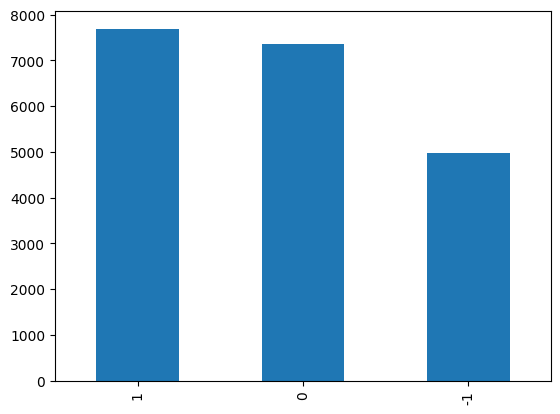

In [12]:
# Plotting the same in bar chart
data['sentiment'].value_counts().plot.bar()

In [13]:
#write percentages of tweets according to sentiments
positive = (len(data[data['sentiment'] == 1])/len(data['sentiment'])) * 100
print(round(positive,2), '% Positive')

38.44 % Positive


In [14]:
neutral = (len(data[data['sentiment'] == 0])/len(data['sentiment'])) * 100
print(round(neutral,2), '% Neutral')

36.72 % Neutral


In [15]:
negative = (len(data[data['sentiment'] == -1])/len(data['sentiment'])) * 100
print(round(negative,2), '% Negative')

24.83 % Negative


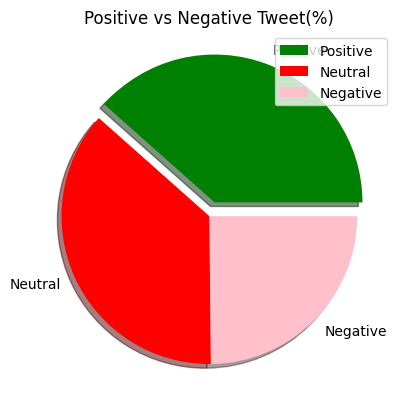

In [16]:
positive = (len(data[data['sentiment'] == 1])/len(data['sentiment'])) * 100
neutral = (len(data[data['sentiment'] == 0])/len(data['sentiment'])) * 100
negative = (len(data[data['sentiment'] == -1])/len(data['sentiment'])) * 100

labels = ['Positive','Neutral','Negative']
values = np.array([positive,neutral,negative])
myexplode = [0.1,0, 0]
mycolors = ["green", "red","pink"]

fig,ax = plt.subplots()
ax.pie(values, labels = labels, explode = myexplode, shadow = True, colors = mycolors)
ax.legend()
ax.set_title("Positive vs Negative Tweet(%)")
fig.show()

In [17]:
# Converting the neutral sentiment value "0" to "1"  and negative sentiment value "-1 to "0" in the target variable for better understanding
data['sentiment'] = data['sentiment'].apply(lambda x : 1 if x == 0 else x)
data['sentiment'] = data['sentiment'].apply(lambda x : 0 if x == -1 else x)
data.head()

,tweet,sentiment
0,"@JasonDub21 @ChildrensNatl As I said, obviousl...",0
1,CDC cautiously optimistic that monkeypox outbr...,1
2,"Near Richmond, CA in the SF Bay Area? Need a m...",1
3,@dot5_ @BruceAllmiighty So it seems the monkey...,1
4,@ErikBateson Monkeypox about to be poppin!,1


In [18]:
# Storing text data in lists for further processing
text,sentiment= list(data['tweet']),list(data['sentiment'])

## <a name="p5">Data Preprocessing</a>

**Text Preprocessing** is an important step for **Natural Language Processing (NLP)** tasks. It transforms text into a more digestible form so that machine learning algorithms can perform better.

**The Preprocessing steps taken are:**
1. **Lower Casing:** Each text is converted to lowercase.
2. **Replacing URLs:** Links starting with **"http" or "https" or "www"** are replaced by **"URL"**.
3. **Replacing Emojis:** Replace emojis by using a pre-defined dictionary containing emojis along with their meaning. *(eg: ":)" to "EMOJIsmile")*
4. **Replacing Usernames:** Replace @Usernames with word **"USER"**. *(eg: "@Kaggle" to "USER")*
5. **Removing Non-Alphabets:** Replacing characters except Alphabets with a space.
6. **Removing Consecutive letters:** 3 or more consecutive letters are replaced by 2 letters. *(eg: "Heyyyy" to "Heyy", "Niceee" to "Nice")*
7. **Removing Short Words:** Words with length less than 2 are removed.
8. **Removing Stopwords:** Stopwords are the English words which does not add much meaning to a sentence. They can safely be ignored without sacrificing the meaning of the sentence. *(eg: "the", "he", "have")*
9. **Lemmatizing:** Lemmatization is the process of converting a word to its base form. *(e.g: “Great” to “Good”)*

#### Please note that below words in nltk stop word list not kept in our custom list defined below
["you're", "you've", "you'll", "you'd", "she's", "it's", "that'll", 'but', 'against', 'off', 'over', 'no', 'nor', 'not', 'don', "don't", "should've", 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn', "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'mightn', "mightn't", 'mustn', "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", "won't", 'wouldn', "wouldn't"]

In [19]:
# stop = stopwords.words('english')

In [20]:
# Defined a method with all preprocessing functions

def preprocess(textdata):
    
    # Defining dictionary containing all emojis with their meanings.
    emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
              ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
              ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
              ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
              '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
              '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
              ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

    stopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
                 'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
                 'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
                 'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
                 'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
                 'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
                 'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
                 'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
                 'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
                 's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
                 't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
                 'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
                 'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
                 'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
                 'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
                 "youve", 'your', 'yours', 'yourself', 'yourselves']


    processedText = []
        
    # Defining regex patterns.
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    userPattern       = '@[^\s]+'
    # alphaPattern      = "[^a-zA-Z0-9]"
    alphaPattern      = "[^a-zA-Z]"
    sequencePattern   = r"(.)\1\1+"
    seqReplacePattern = r"\1\1"
    
    for tweet in textdata:
        tweet = tweet.lower()
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet)
        
        # Replace all emojis.
        for emoji in emojis.keys():
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])    
            
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)  
        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet)
        
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet)
        
        #Removing punctuations if any left post removing all all non alphabets
        all_char_list = []
        all_char_list = [char for char in tweet if char not in string.punctuation]
        tweet = ''.join(all_char_list)
        
        # Removing all stopwords as per custom list defined above
        tweetwords = ''
        for word in tweet.split():
            if word not in (stopwordlist):
                if len(word)>1:
                    # Lemmatizing the word.
                    # text_pos = pos_tag(word_tokenize(word))
                    # word = lemma.lemmatize(text_pos[0][0],get_wordnet_pos_tag(text_pos[0][1]))
                    # word = wordLemm.lemmatize(word)
                    tweetwords += (word+' ')
            
        processedText.append(tweetwords)
        
    return processedText

In [21]:
# Applying the entire text stored in list "text" for preprocessing and calculating the time taken to perform the operation
t = time.time()
preprocessedtext = preprocess(text)
print('Text Preprocessing complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Preprocessing complete.
Time Taken: 5 seconds


In [22]:
# Defining a method to return the 2nd parameter for lemmatization that is POS tag
def get_wordnet_pos_tag(tag):
    if tag.startswith("J"):
        return wordnet.ADJ
    if tag.startswith("V"):
        return wordnet.VERB
    if tag.startswith("N"):
        return wordnet.NOUN
    if tag.startswith("R"):
        return wordnet.ADV
    else:
        return wordnet.NOUN

In [23]:
# Created a method to perform lemmatization with POS tags identified via a pos_tag method
def lemmatize_process(preprocessedtext):
    # Create Lemmatizer
    lemma = WordNetLemmatizer()
    
    finalprocessedtext = []
    for tweet in preprocessedtext:
        text_pos = pos_tag(word_tokenize(tweet))
        words = [x[0] for x in text_pos]
        pos = [x[1] for x in text_pos]
        tweet_lemma = " ".join([lemma.lemmatize(a,get_wordnet_pos_tag(b)) for a,b in zip(words,pos)])
        finalprocessedtext.append(tweet_lemma)
    return finalprocessedtext

In [24]:
# Applying the entire text stored in list "text" for preprocessing and calculating the time taken to perform the operation
t = time.time()
processedtext = lemmatize_process(preprocessedtext)
print('Text Lemmatization complete.')
print(f'Time Taken: {round(time.time()-t)} seconds')

Text Lemmatization complete.
Time Taken: 89 seconds


## <a name="p6">Data Analysis</a>

In [25]:
# Created a method using WhitespaceTokenizer and FreqDist to identify the most frequent set of words in the datset segregated
# by target variable

token_wspace = tokenize.WhitespaceTokenizer()

def mostFrequentWords(tweets,quantity):
    all_words = ' '.join(tweets)
    all_tokens = token_wspace.tokenize(all_words)
    freq_dist = nltk.FreqDist(all_tokens)
    df_frequency = pd.DataFrame({"Word":list(freq_dist.keys()), "Frequency":list(freq_dist.values())})
    df_frequency = df_frequency.nlargest(columns="Frequency", n=quantity)
    plt.figure(figsize=(12,8))
    ax = sns.barplot(data = df_frequency, x = "Word", y = "Frequency", color = 'blue')
    ax.set(ylabel = "Count")
    plt.xticks(rotation='vertical')
    plt.show()

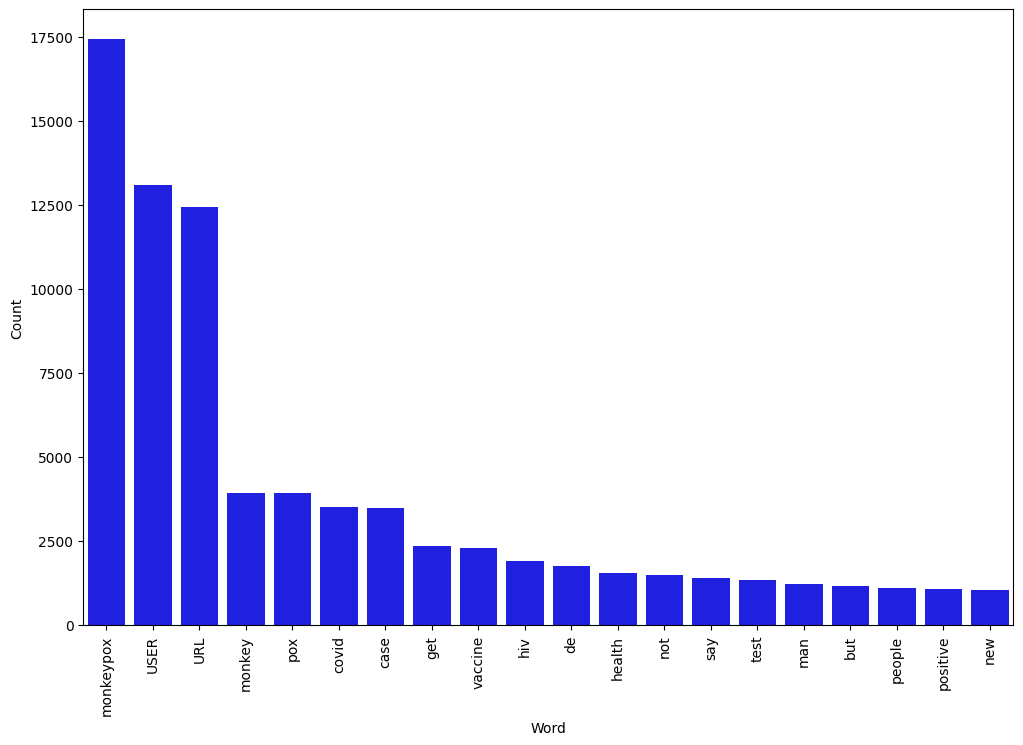

In [26]:
# Calling the above method for negative cases, plotting the most frequent top 10 words
mostFrequentWords(processedtext,20)

## <a name="p7">Splitting the Data</a>
In this step will would be spiltting the dataset into train and test set fo modeling 

In [27]:
# Splitting the entire set into train and test with test size of 5%
X_train, X_test, y_train, y_test = train_test_split(processedtext, sentiment,
                                                    test_size = 0.05, random_state = 0)
print('Data Split done..')

Data Split done..


## <a name="p8">TF-IDF Vectoriser</a>

**TF-IDF indicates the importance of a word, in order to understand the document or dataset.** Let us understand with an example. Suppose you have a dataset where students write an essay on the topic, My Bike. In this dataset, the bike word appears many times; it’s a high frequency word compared to other words in the dataset. The dataset contains other words like street, long ride, helmets and so on that appear less often, so their frequency are lower and they carry more information compared to the word. This is the intuition behind TF-IDF.

**TF-IDF Vectoriser** converts a collection of raw documents to a **matrix of TF-IDF features**. The **Vectoriser** is usually trained on only the **train** dataset. 

**ngram_range**  is the range of number of words in a sequence. *[e.g "very expensive" is a 2-gram that is considered as an extra feature separately from "very" and "expensive" when you have a n-gram range of (1,2)]*

**max_features** specifies the number of features to consider. *[Ordered by feature frequency across the corpus]*.

In [28]:
# Fitting TFIDF vectorizer on the train dataset 
vectoriser = TfidfVectorizer(ngram_range=(1,2), max_features=500000)
vectoriser.fit(X_train)
print('Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

Vectoriser fitted.
No. of feature_words:  141037


### <a name="p9">Tranforming the dataset</a>

In [29]:
# Transforming the X_train and X_test dataset on the fitted model
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Data Transformed.')

Data Transformed.


## <a name="p10">Creating and Evaluating Models</a>

We're creating 4 different types of model for our sentiment analysis problem: 
* **Linear Support Vector Classification (LinearSVC)**
* **Bernoulli Naive Bayes (BernoulliNB)**
* **Logistic Regression (LR)**
* **Random Forest Model (RF)**

Since our dataset is **Not balanced**, i.e. it does not have equal number of **Positive and Negative** Predictions. We're choosing **F1 score** as our evaluation metric cos it is used to evaluate imbalanced dataset . Furthermore, we're plotting the **Confusion Matrix** and **ROC Curve** to get an understanding of how our model is performing on both classification types.

In [30]:
# Creating a method which will take the model object and then predict on the test set and evaluate on Accuracy, 
# Confusion Matrix and ROC Curve

def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test)

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos']
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)]

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)
    
    
    plt.title ("ROC Curve")
    #Area under Curve
    fpr, tpr, thresholds = roc_curve(y_test, y_pred)
    roc_auc = auc(fpr, tpr)
    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=1, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC CURVE')
    plt.legend(loc="lower right")
    plt.show()
    
    return y_pred

### <a name="p10-1">LinearSVC Model</a>

              precision    recall  f1-score   support

           0       0.86      0.83      0.84       258
           1       0.94      0.95      0.95       743

    accuracy                           0.92      1001
   macro avg       0.90      0.89      0.89      1001
weighted avg       0.92      0.92      0.92      1001



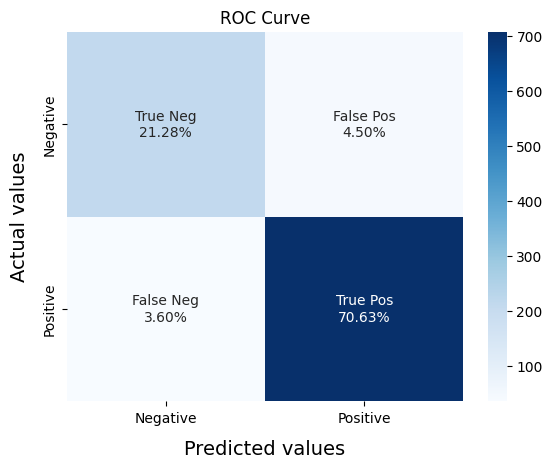

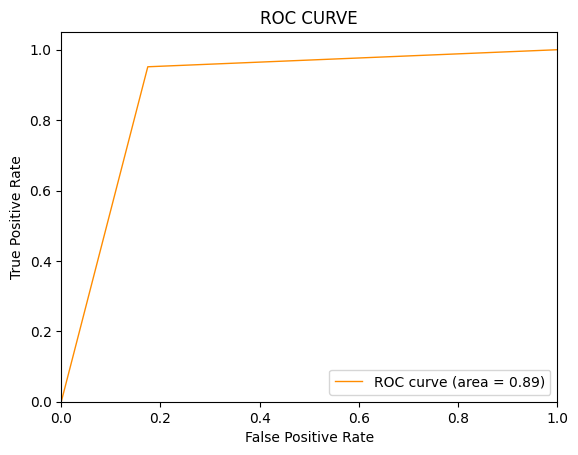

In [31]:
# Created a Linear SVM model with default parameters and then evaluating the model

SVCmodel = LinearSVC()
SVCmodel.fit(X_train, y_train)
y_test_pred=model_Evaluate(SVCmodel)

### <a name="p10-2">BernoulliNB Model</a>

              precision    recall  f1-score   support

           0       0.83      0.02      0.04       258
           1       0.75      1.00      0.85       743

    accuracy                           0.75      1001
   macro avg       0.79      0.51      0.45      1001
weighted avg       0.77      0.75      0.64      1001



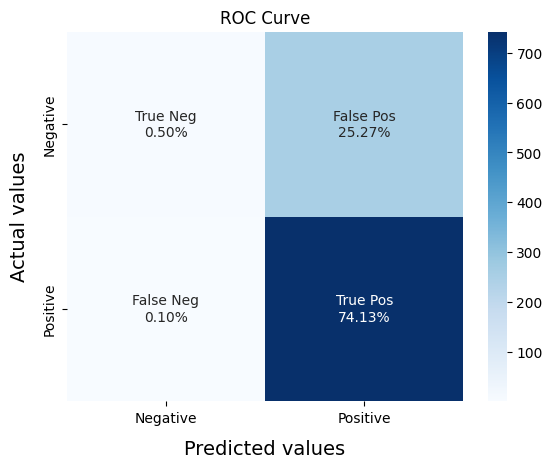

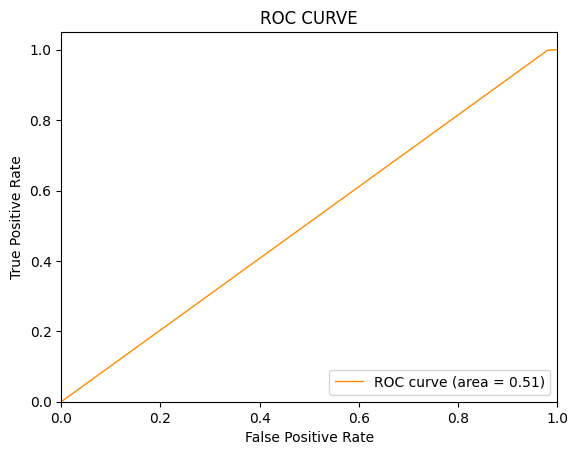

array([1, 1, 1, ..., 1, 1, 1])

In [32]:
# Created a Bernoulli Naive Bayes model with default parameters and then evaluating the model

BNBmodel = BernoulliNB(alpha = 2)
BNBmodel.fit(X_train, y_train)
model_Evaluate(BNBmodel)

### <a name="p10-3">Logistic Regression Model</a>

              precision    recall  f1-score   support

           0       0.78      0.67      0.72       258
           1       0.89      0.93      0.91       743

    accuracy                           0.87      1001
   macro avg       0.83      0.80      0.82      1001
weighted avg       0.86      0.87      0.86      1001



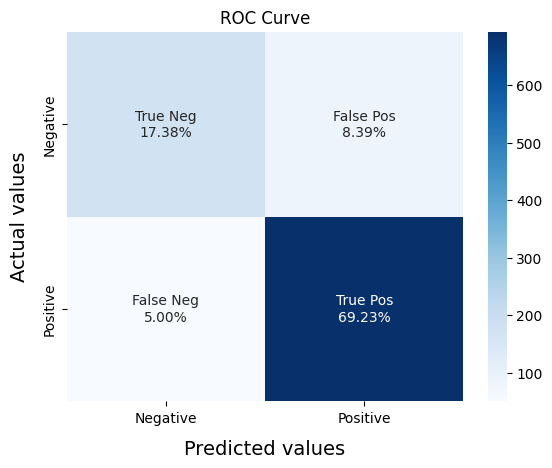

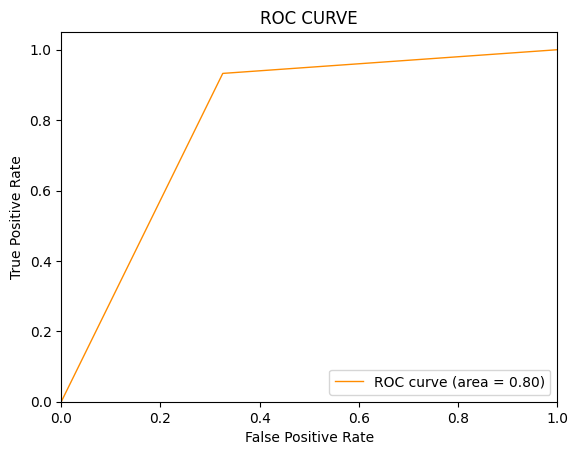

array([1, 1, 0, ..., 0, 0, 0])

In [33]:
# Created a Logistic Regression model with regularization parameter and max iteration limit and then evaluating the model
LRmodel = LogisticRegression(C = 1, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)

### <a name="p10-4">Random Forest Model</a>

              precision    recall  f1-score   support

           0       0.81      0.75      0.78       258
           1       0.91      0.94      0.93       743

    accuracy                           0.89      1001
   macro avg       0.86      0.84      0.85      1001
weighted avg       0.89      0.89      0.89      1001



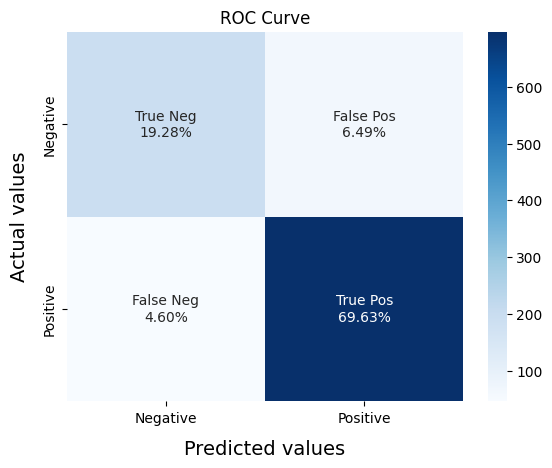

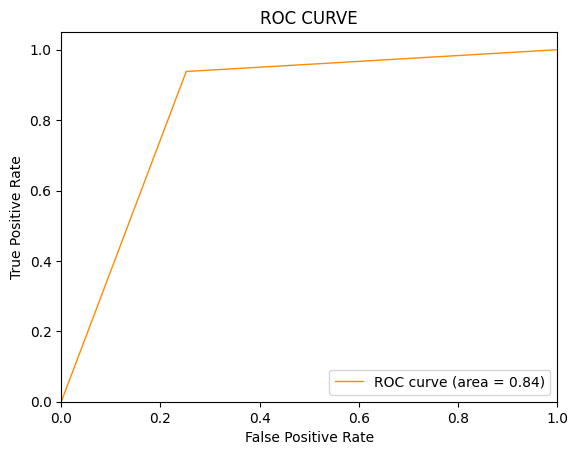

array([1, 1, 0, ..., 0, 0, 1])

In [34]:
# Created a Linear RandomForest model with default parameters and then evaluating the model

RFmodel = RandomForestClassifier(n_estimators = 150, random_state = 101)
RFmodel.fit(X_train, y_train)
model_Evaluate(RFmodel)

It is obvious that the linear SVC model outperforms the other models we tested. It is a solid model for categorizing the sentiment of a tweet because it has a **92% F1 score and an 89% ROC curve**. Additionally, the model can identify 70.63% of the tweets as true positives. 21.28% of the tweets may be classified by the model as being truly negative. Additionally, the model categorizes 4.50% of the tweets as falsely positive. 3.60 percent of the tweets are categorized by the program as false negatives. We can conclude that the SVC model performs better using the evelution metric.


However it should also be noted that the **BernoulliNB Model** is the fastest to train and predict on. It also achieves **64% F1 score** while classifying.
>Note: A true positive is an outcome where the model correctly predicts the positive class. Similarly, a true negative is an outcome where the model correctly predicts the negative class.**
A false positive is an outcome where the model incorrectly predicts the positive class. And a false negative is an outcome where the model incorrectly predicts the negative class.**


In [35]:
# Printing the positive and negative sentiment on the test data based on logistic regression model
print("Positive Sentiment Percentage : {}%".format(round(np.count_nonzero(y_test_pred == 1)/len(y_test_pred)*100,2)))

print("Negative Sentiment Percentage : {}%".format(round(np.count_nonzero(y_test_pred == 0)/len(y_test_pred)*100,2)))

Positive Sentiment Percentage : 75.12%
Negative Sentiment Percentage : 24.88%


## <a name="p11">Saving the Model</a>
We're using **PICKLE** to save **Vectoriser and LinearSVC Model** for later use.

In [107]:
# Storing the vectorizer object and Logistic Regression object in pickle files for later use

file = open('../model/vectoriser.pickle','wb')
pickle.dump(vectoriser, file)
file.close()

file = open('../model/Sentiment-SVC.pickle','wb')
pickle.dump(SVCmodel, file)
file.close()

## <a name="p12">Using the Model</a>

To use the model for **Sentiment Prediction** we need to import the **Vectoriser** and **SVC Model** using **Pickle**.

The vectoriser can be used to transform data to matrix of TF-IDF Features.
While the model can be used to predict the sentiment of the transformed Data.
The text whose sentiment has to be predicted however must be preprocessed.

In [36]:
# Created a method to load the models from pickle file
def load_models():  
       
    # Load the vectoriser.
    file = open('../model/vectoriser.pickle', 'rb')
    vectoriser = pickle.load(file)
    file.close()
    
    # Load the LR Model.
    file = open('../model/Sentiment-SVC.pickle', 'rb')
    LRmodel = pickle.load(file)
    file.close()
    
    return vectoriser, LRmodel


# Created a method to perform tfidf vectorizer on unseen data and then using the model loaded from pickle file to predict 
# whether positive or negative and also the probability along with it.
# Do note the unseen data should be passed to the model in a list
def predict(vectoriser, model, text):
    finaldata = []

    textdata = vectoriser.transform(lemmatize_process(preprocess(text)))
    sentiment = model.predict(textdata)
    
    # print(model.classes_)
    sentiment_prob = model._predict_proba_lr(textdata)
    
    for index,tweet in enumerate(text):
        if sentiment[index] == 1:
            sentiment_probFinal = sentiment_prob[index][1]
        else:
            sentiment_probFinal = sentiment_prob[index][0]
            
        sentiment_probFinal2 = "{}%".format(round(sentiment_probFinal*100,2))
        finaldata.append((tweet, sentiment[index], sentiment_probFinal2))
           
    # Convert the list into a Pandas DataFrame.
    df = pd.DataFrame(finaldata, columns = ['tweet','sentiment', 'Confidence level'])
    df = df.replace([0,1], ["Negative","Positive"])
    return df

In [37]:
# Text to classify should be in a list.
text = ["Monkeypox vaccine supply now sufficient",
        "Monkeypox ramping up during mosquito bite season is really just nature is truly gonna fuck with us while it gets us on up outta here",
        "It's monkeypox, VD, and zombies in them streets. I'm good. I'll be in the house watching YouTube and listening to Twitter Spaces",
        "The COVID,HIV and Monkeypox coming like ",
       "Health officials update approach to monkeypox outbreak as U.S becomes leader in infections",
       "While about 26% of monkeypox cases have affected white individuals, about 53% of vaccines have gone to white people"]

#### The goal of this project is to identify public opinion that has been associated to the rapidly spreading monkey pox outbreak using textual analytics of Twitter data.

In [38]:
# Calling the load model method and then calling predict method by passing the tfidf vectorizer and model as parameter
# Finally printing the dataframe containing tweet, sentiment and the probability confidence.
vectoriser, LRmodel = load_models()
df = predict(vectoriser, LRmodel, text)
df.sort_values(by=['Confidence level'],ascending=False,inplace=True)
df

,tweet,sentiment,Confidence level
4,Health officials update approach to monkeypox ...,Positive,74.37%
2,"It's monkeypox, VD, and zombies in them street...",Positive,72.17%
0,Monkeypox vaccine supply now sufficient,Positive,71.49%
3,"The COVID,HIV and Monkeypox coming like",Positive,69.55%
5,While about 26% of monkeypox cases have affect...,Positive,67.8%
1,Monkeypox ramping up during mosquito bite seas...,Negative,64.53%


In light of the test tweet's above prediction, we may conclude that there are more positive than negative tweets. As a result, we can conclude that people do not actually view monkeypox as a serious threat to their lives.

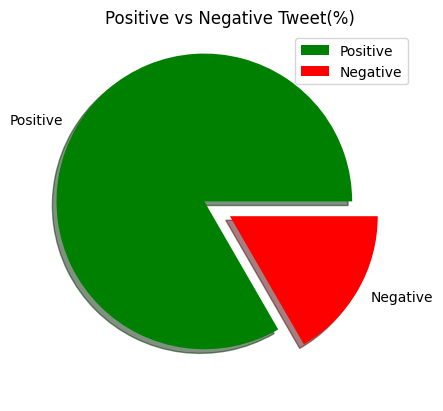

In [39]:
positive = round(np.count_nonzero(df['sentiment'] == "Positive")/len(df['sentiment'])*100,2)
negative = round(np.count_nonzero(df['sentiment'] == "Negative")/len(df['sentiment'])*100,2)

labels = ['Positive','Negative']
values = np.array([positive,negative])
myexplode = [0.2, 0]
mycolors = ["green", "red"]

fig,ax = plt.subplots()
ax.pie(values, labels = labels, explode = myexplode, shadow = True, colors = mycolors)
ax.legend()
ax.set_title("Positive vs Negative Tweet(%)")
fig.show()